In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import padelpy
import rdkit        

In [3]:
from torch_geometric.datasets import MoleculeNet

# dataset = MoleculeNet(root='/data', name='SIDER')
from datasets.fishtox import FishTox
dataset = FishTox('../data')


/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
targets = dataset.y
all_labels = (targets != targets).sum()==0
smiles =  dataset.smiles
targets = dataset.y
torch.sum(targets!=targets), targets.shape

(tensor(0), torch.Size([907, 1]))

In [5]:
len(smiles)

907

OCCN1CCNCC1 tensor(1.3078)


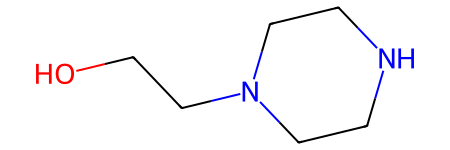

In [6]:
from rdkit import Chem
import matplotlib.pyplot as plt
# smile = "C(CSC[C@@H]1[C@@H]2[C@@H]([C@H]([C@H](O1)O[C@@H]3[C@H](O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]4[C@H](O[C@@H]([C@@H]([C@H]4O)O)O[C@@H]5[C@H](O[C@@H]([C@@H]([C@H]5O)O)O[C@@H]6[C@H](O[C@@H]([C@@H]([C@H]6O)O)O[C@@H]7[C@H](O[C@@H]([C@@H]([C@H]7O)O)O[C@@H]8[C@H](O[C@@H]([C@@H]([C@H]8O)O)O[C@@H]9[C@H](O[C@H](O2)[C@@H]([C@H]9O)O)CSCCC(=O)[O-])CSCCC(=O)[O-])CSCCC(=O)[O-])CSCCC(=O)[O-])CSCCC(=O)[O-])CSCCC(=O)[O-])CSCCC(=O)[O-])O)O)C(=O)[O-].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+].[Na+]"
idx = 32
smile = smiles[idx]
print(smile, targets[idx].sum())
Chem.MolFromSmiles(smile,)

In [7]:
from fingerprint import AtomPairs2DFingerprinter, KlekotaRothFingerprintCount, MACCSFingerprinter, SubstructureFingerprintCount, PubchemFingerprinter, EStateFingerprinter, ChemBERTaFingerprinter
from fingerprint.cached import CachedFingerprinter

# fp_extractor = MACCSFingerprinter()
# 
fp_extractor = CachedFingerprinter(
    fingerprinter=PubchemFingerprinter(),
    cache_path='/data/fingerprints',
    read_only=True
)

fingerprints = fp_extractor(smiles)


Using 24 threads.


In [21]:
import pandas as pd
data = []
fingerprint_name = 'PubChem'
target_name = 'LC50'

for i in range(fingerprints.shape[0]):
    entry = {f"{fingerprint_name}_{j+1}": fingerprints[i,j] for j in range(fingerprints.shape[1])}
    entry.update({f"{target_name}_{j+1}": targets[i,j] for j in range(targets.shape[1])})
    data.append(entry)
data = pd.DataFrame(data)

In [27]:
data.to_csv('pubmed_fishtox.csv', index=False)

In [29]:
fp_extractor.n_dim

881

In [161]:
import numpy as np
from tqdm.auto import tqdm

fingerprints = fp_extractor(smiles)
n_ids_to_test = 24

rand_ids = np.random.choice(len(smiles), n_ids_to_test)
rand_smiles = [dataset.smiles[idx] for idx in rand_ids]
rand_fingerprints = fp_extractor.fingerprinter(rand_smiles)

n_consistent = ((fingerprints[rand_ids] != rand_fingerprints).sum(-1)==0).sum()
print(f"{n_consistent}/{n_ids_to_test}")

100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

24/24


In [162]:
del fp_extractor

In [163]:
print(len(fingerprints))
valid_mask = (fingerprints!=fingerprints).sum(-1) == 0

fingerprints = fingerprints[valid_mask]
targets = targets[valid_mask]
smiles = [smile for i, smile in enumerate(smiles) if valid_mask[i]]
print(len(fingerprints), len(targets))


907
907 907


C1(=O)C(Cl)=C(SCc2ccc(C(C)(C)C)cc2)C=NN1C(C)(C)C tensor(8.2005)


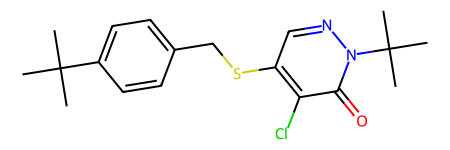

In [164]:
smile = smiles[idx]
print(smile, targets[idx].sum())
Chem.MolFromSmiles(smile,)

In [165]:
import numpy as np

n_train = 800
train_ids = np.random.choice(fingerprints.shape[0], n_train, replace=False)
test_ids = [idx for idx in range(len(fingerprints)) if not(idx in train_ids)]


train_fingerprints = fingerprints[train_ids]
train_targets = targets[train_ids]
test_fingerprints = fingerprints[test_ids]
test_targets = targets[test_ids]

print(len(train_ids), len(test_ids), fingerprints.shape[0])

800 107 907


In [166]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [167]:
from torch_mist.estimators import smile, TransformedMIEstimator, js, doe, SMILE
from torch_mist.critic import SeparableCritic, critic_nn, JointCritic
from torch_mist.nn import Normalize
from torch import nn

z_dim = 64
k_dim = 32

drop_p = 0.5

# critic = SeparableCritic(
#     f_x=nn.Sequential(
#         nn.Linear(z_dim, 128),
#         nn.Dropout(drop_p),
#         nn.ReLU(True),
#         nn.Linear(128, k_dim),
#         Normalize()
#     ),
#     f_y=nn.Sequential(
#         nn.Linear(targets.shape[-1], 64),
#         nn.Dropout(drop_p),
#         nn.ReLU(True),
#         nn.Linear(64, k_dim),
#         Normalize()
#     )
# )

critic = JointCritic(
    joint_net=nn.Sequential(
        nn.Linear(fingerprints.shape[-1]+targets.shape[-1], 256),
        nn.ReLU(True),
        nn.Dropout(drop_p),
        nn.Linear(256, 64),
        nn.ReLU(True),
        nn.Dropout(drop_p),
        nn.Linear(64, 1)
    )
)

print(targets.shape)
estimator = SMILE(
        critic=critic,
        neg_samples=-1,
    )


estimator

torch.Size([907, 1])


SMILE(
  (ratio_estimator): JointCritic(
    (joint_net): Sequential(
      (0): Linear(in_features=882, out_features=256, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=256, out_features=64, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (baseline): BatchLogMeanExp()
  (neg_samples): -1
)

In [168]:
# from typing import List, Callable
# from sklearn.neighbors import KernelDensity
# from torch.distributions import Distribution
# 
# class KDEDistribution(Distribution):
#     def __init__(self, kde: KernelDensity):
#         super().__init__(validate_args=False)
#         self.kde = kde
# 
#     def log_prob(self, value: torch.Tensor) -> torch.Tensor:
#         device = value.device
#         shape = value.shape[:-1]
#         flat_log_prob = self.kde.score_samples(value.view(-1,value.shape[-1]).data.numpy())
#         log_prob = torch.FloatTensor(flat_log_prob).view(shape).to(device)
#         return log_prob
# 
# 
# kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(targets.data.numpy())
# 
# from torch_mist.estimators import DoE
# from torch_mist.distributions import ConditionalTransformedNormalModule
# from torch_mist.distributions.transforms import ConditionalLinear
# from pyro.distributions.transforms import ConditionalSpline, BatchNorm
# 
# 
# class Apply(nn.Module):
#     def __init__(self, f: Callable, **kwargs):
#         super().__init__()
#         self.f = f
#         self.kwargs = kwargs
#         
#     def forward(self, x: torch.Tensor):
#         return self.f(x, **self.kwargs)
# p_drop = 0
# 
# estimator = DoE(
#     q_Y=KDEDistribution(kde),
#     q_Y_given_X=ConditionalTransformedNormalModule(
#         input_dim=1,
#         transforms=[ConditionalLinear(
#             net=nn.Sequential(
#                 nn.Linear(fingerprints.shape[-1], 128),
#                 nn.ReLU(True),
#                 nn.Dropout(drop_p),
#                 nn.Linear(128, 64),
#                 nn.ReLU(True),
#                 nn.Dropout(drop_p),
#                 nn.Linear(64, 2),
#                 Apply(torch.chunk, chunks=2, dim=-1)
#             )
#         )
#         ]
#     )
# )


In [169]:
from torch_mist.utils.train import train_mi_estimator
from torch.optim import AdamW
import torch

device='cpu'
train_log = train_mi_estimator(
    estimator=estimator,
    x=train_fingerprints,
    y=train_targets,
    batch_size=64,
    max_epochs=40,
    optimizer_class=AdamW,
    valid_percentage=0.1,
    device=device,
)


Iteration: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s, loss: 1.0642776489257812]


(0.0, 0.5987084774370306)

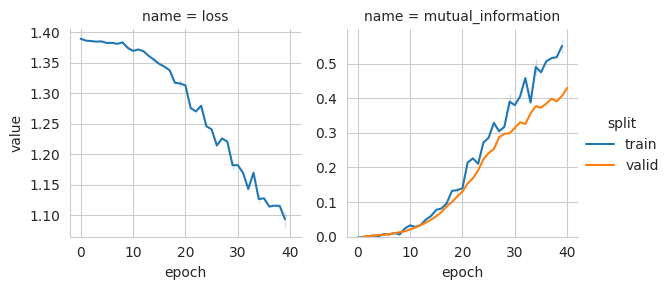

In [170]:
import seaborn as sns

grid = sns.FacetGrid(train_log, col='name', hue='split', sharey=False, col_order=['loss', 'mutual_information'])
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()
grid.axes[0,1].set_ylim(0,)

C1(=O)C(Cl)=C(SCc2ccc(C(C)(C)C)cc2)C=NN1C(C)(C)C tensor(8.2005)


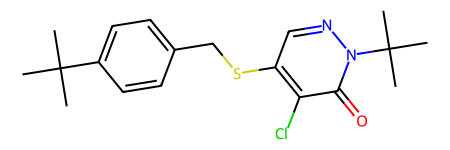

In [171]:
smile = smiles[idx]
print(smile, targets[idx].sum())
Chem.MolFromSmiles(smile,)

In [172]:
mi = {
    'MACCS': 0.17441825568675995,
    # 'AP2DC': 0.27732696999674256,
    'KRC': 0.049717605113983154,
    # 'SSC': 0.24206119063107864,
    'EState': 0.4160766303539276,
    # 'PubChem': 0.33733838001887,
    'ChemBERTa': 0.4468282610177994,
}

In [173]:
from torch_mist.utils import evaluate_mi
mask = np.concatenate([test_ids])
estimator.eval()
mi['PubChem'] = evaluate_mi(estimator, x=fingerprints.astype(np.float32)[mask], y=targets.float()[mask], batch_size=64)

In [174]:
mi

{'MACCS': 0.17441825568675995,
 'KRC': 0.049717605113983154,
 'EState': 0.4160766303539276,
 'ChemBERTa': 0.4468282610177994,
 'PubChem': 0.5301228165626526}

In [175]:
fingerprints.shape[-1]

881

/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/marco/anaconda3/envs/InfoMol/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/marco/a

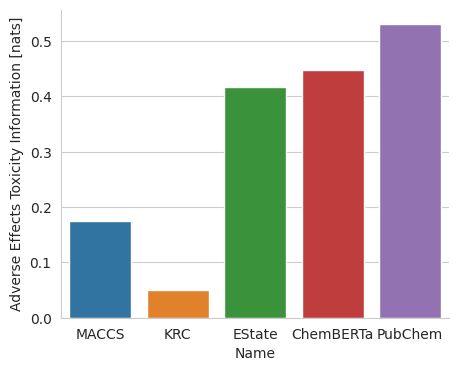

In [176]:
import pandas as pd
import seaborn as sns
f, ax = plt.subplots(1,1,figsize=(5,4))
y_name = 'Adverse Effects Toxicity Information [nats]'
sns.barplot(pd.DataFrame([{'Name': key, y_name: value} for key, value in mi.items()]),
            x='Name', y=y_name, hue='Name')
sns.despine()

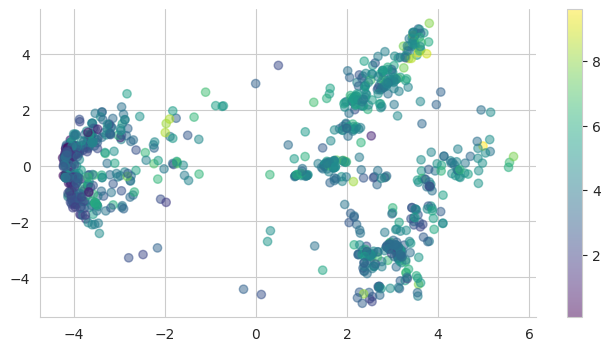

In [177]:
from sklearn.decomposition import PCA
import seaborn as sns


tox_proj = targets.sum(-1)
z0 = PCA(2).fit_transform(fingerprints)

f, ax = plt.subplots(1,1, figsize=(8, 4))

scatter = ax.scatter(z0[:,0], z0[:,1], c=tox_proj, alpha=0.5, marker='o', cmap='viridis')
sns.despine()
plt.colorbar(scatter)

In [178]:
targets.shape

torch.Size([907, 1])

In [179]:
from rdkit.Chem.Descriptors import ExactMolWt

from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(targets.data.numpy())

res = 1000
t = torch.linspace(-3,15, res).view(-1,1)
estimator.eval()
u_log_r = estimator.unnormalized_log_ratio(torch.FloatTensor(fingerprints).unsqueeze(1), t.unsqueeze(0)).data.numpy()
print(u_log_r.shape)
p_tox = np.exp(u_log_r+kde.score_samples(t).reshape(1,-1))
print(p_tox.shape)
best_prediction = t[np.argmax(p_tox, -1)].view(-1)

w = np.array([ExactMolWt(Chem.MolFromSmiles(smile)) for smile in smiles])

(907, 1000)
(907, 1000)


In [180]:
residuals = (targets.squeeze()-best_prediction)
error_order = np.argsort(residuals[test_ids]**2)
len(test_ids), len(train_ids)

(107, 800)

In [181]:
best_prediction.shape

torch.Size([907])

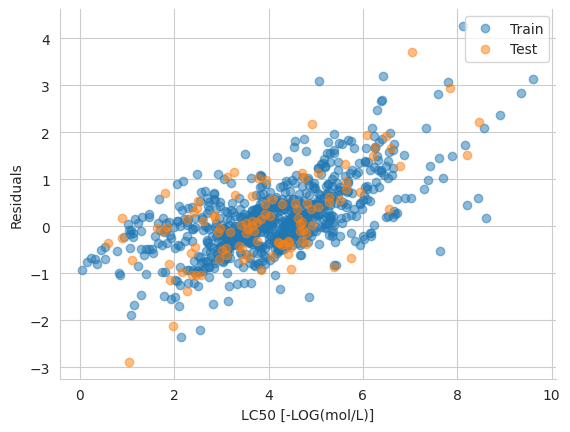

In [182]:
plt.plot(targets[train_ids,0], residuals[train_ids], 'o', alpha=0.5, label='Train')
plt.plot(targets[test_ids,0], residuals[test_ids], 'o', alpha=0.5, label='Test')
plt.legend()
plt.xlabel('LC50 [-LOG(mol/L)]')
plt.ylabel('Residuals')
sns.despine()

Text(0, 0.5, 'Residuals')

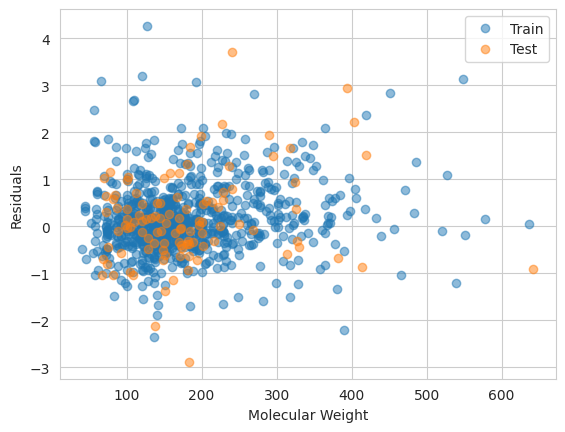

In [183]:
plt.plot(w[train_ids], residuals[train_ids], 'o', alpha=0.5, label='Train')
plt.plot(w[test_ids], residuals[test_ids], 'o', alpha=0.5, label='Test')
plt.legend()
plt.xlabel('Molecular Weight')
plt.ylabel('Residuals')

Text(0.5, 0, 'Residuals')

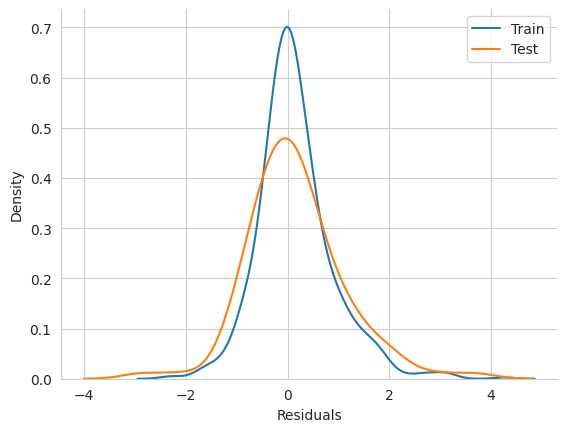

In [184]:
f, ax = plt.subplots(1,1)
sns.kdeplot(residuals[train_ids], label='Train', ax=ax)
sns.kdeplot(residuals[test_ids], label='Test', ax=ax)
ax.legend()
sns.despine()
ax.set_xlabel('Residuals')

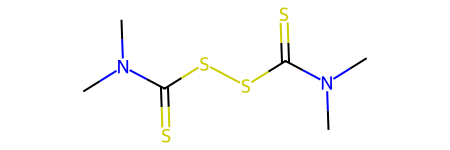

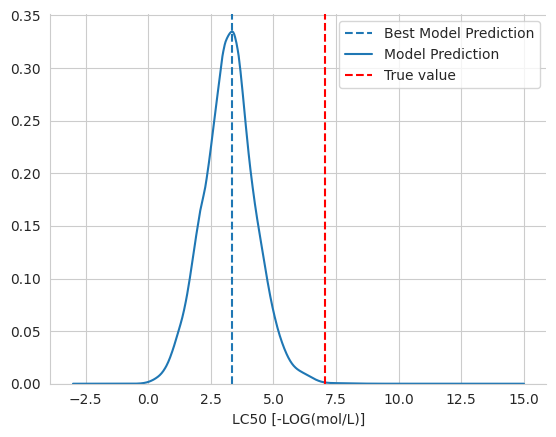

In [186]:
idx = test_ids[error_order[-1]]

target = targets[idx]

plt.axvline(x=best_prediction[idx], ls='--', label='Best Model Prediction')

plt.plot(t, p_tox[idx], label='Model Prediction')
plt.axvline(x=target, ls='--', color='r', label='True value')
plt.legend()
plt.ylim(0,)
plt.xlabel('LC50 [-LOG(mol/L)]')

sns.despine()
smile = smiles[idx]
Chem.MolFromSmiles(smile,)

In [124]:
mol = Chem.MolFromSmiles(smile,)




In [125]:
emb = nn.Sequential(
    encoder,
    estimator.base_estimator.critic.f_x,
)
emb

NameError: name 'encoder' is not defined

In [27]:
fingerprints.shape

(1426, 881)

tensor(1141)
tensor(1.)


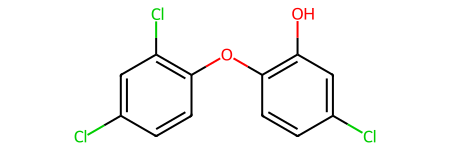

In [28]:
from rdkit.Chem import Draw

q_idx = np.argsort(tox_proj)[0]
print(q_idx)
print(tox_proj[q_idx])
q_m = Chem.MolFromSmiles(smiles[q_idx],)
q_m

In [29]:
all_emb = emb(torch.FloatTensor(fingerprints))
all_emb = all_emb-all_emb.mean(dim=0, keepdim=True)
all_emb = torch.nan_to_num(all_emb/all_emb.norm(dim=-1, keepdim=True), 0)

scores = all_emb[q_idx] @ all_emb.T
scores = scores.data
score_idx = np.argsort(scores)

[1141, 150, 787, 305, 567]
tensor([ 1., 14.,  4., 16., 23.])


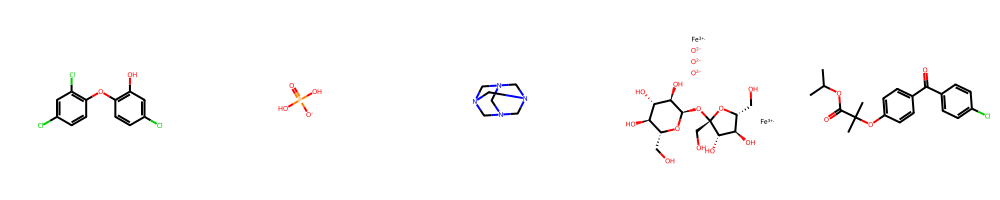

In [30]:
n_candidates = 5

r_ids = [score_idx[-1-idx].item() for idx in range(n_candidates)]
print(r_ids)
print(tox_proj[r_ids])
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles[idx]) for idx in r_ids], 
    molsPerRow=n_candidates
)

[1141, 937, 653, 1368, 789]
tensor([ 1.,  5.,  1.,  3., 16.])


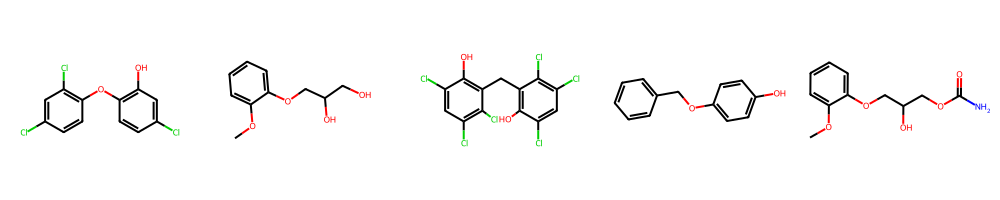

In [31]:
all_emb = torch.FloatTensor(fingerprints)
all_emb = all_emb-all_emb.mean(dim=0, keepdim=True)
all_emb = torch.nan_to_num(all_emb/all_emb.norm(dim=-1, keepdim=True), 0)
scores = all_emb[q_idx] @ all_emb.T
score_idx = np.argsort(scores)

r_ids = [score_idx[-1-idx].item() for idx in range(n_candidates)]
print(r_ids)
print(tox_proj[r_ids])
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles[idx]) for idx in r_ids], 
    molsPerRow=n_candidates
)

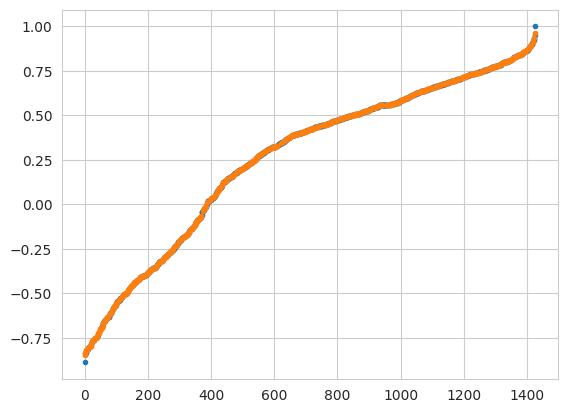

In [32]:
mask = targets[:,0] == 1
plt.plot(np.arange(len(scores))[mask], scores[score_idx][mask], '.')
plt.plot(np.arange(len(scores))[~mask], scores[score_idx][~mask], '.')

In [86]:
from torch.optim import Adam
critic.eval()


toxv = torch.zeros(100, 27)
toxv.uniform_()
toxv = nn.Parameter(toxv, requires_grad=True)
opt =Adam([toxv], lr=1e-3)

fingerprint = torch.FloatTensor(fingerprints[q_idx]).view(1,-1).repeat(100,1)
fingerprint.requires_grad = False
losses = []

from torch_mist.utils.freeze import freeze


for param in estimator.parameters():
    param.requires_grad_(False)
    
from torch.distributions import Beta

for i in range(1000):
    estimator.log_ratio(x=fingerprint-1, y=toxv-1).mean()
    loss = -estimator.log_ratio(x=fingerprint, y=torch.sigmoid(toxv)).mean()
    loss += - Beta(0.1,0.1).log_prob(torch.sigmoid(toxv)).mean()
    losses.append(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()
    


tensor([13.,  6.,  6., 10.,  7., 13., 13.,  7., 12.,  5.,  3., 10.,  2.,  2.,
        10.,  5.,  3.,  3.,  3., 16.,  1.,  3.,  3.,  3.,  3., 11.,  5., 12.,
        11.,  6.,  7.,  5.,  4.,  9.,  5.,  6., 10.,  4.,  6.,  3.,  4.,  5.,
         9.,  5.,  2.,  4.,  4.,  8.,  2.,  2.,  2.,  2.,  2.,  2.,  5.,  2.,
        10.,  8.,  3., 10.,  2.,  3., 11.,  8.,  1.,  1.,  1.,  1.,  1.,  2.,
         7.,  8.,  5.,  8., 12.,  4.,  3.,  7., 12., 10.,  4.,  4.,  7.,  5.,
         6.,  7.,  3.,  5.,  3.,  3.,  4.,  2.,  3.,  2.,  1.,  7.,  1.,  1.,
         1.,  1.])

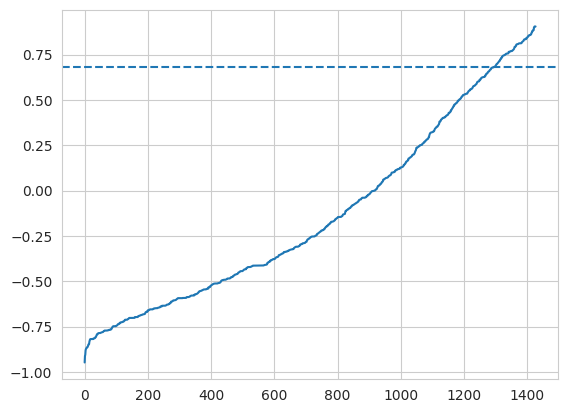

In [109]:
from torch.distributions import Bernoulli
fingerprint = torch.FloatTensor(fingerprints[q_idx]).view(1,-1).repeat(targets.shape[0],1)
log_ratios = estimator.log_ratio(x=fingerprint, y=targets)
order = log_ratios.argsort()
plt.plot(log_ratios[order]) 
plt.axhline(y=log_ratios[q_idx], ls='--')
targets[order][-100:].sum(-1)

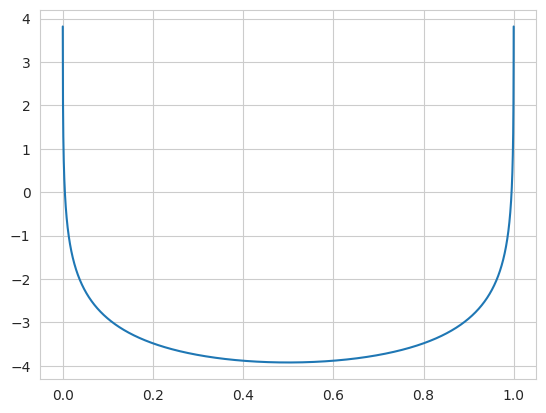

In [89]:
y = torch.linspace(0,1,10000)
plt.plot(y, Beta(0.01,0.01).log_prob(y), )

In [70]:
import pandas as pd
pd.read_csv("/tmp/padelpy/out_140657063092.csv")[[f'SubFP{i}' for i in range(1,308)]].values.shape

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/padelpy/out_140657063092.csv'

In [16]:
!cat /tmp/padelpy/descriptors.xml

<?xml version='1.0' encoding='utf-8'?>
<Root><Group name="Fingerprint"><Descriptor name="Fingerprinter" value="false" /><Descriptor name="ExtendedFingerprinter" value="false" /><Descriptor name="EStateFingerprinter" value="false" /><Descriptor name="GraphOnlyFingerprinter" value="false" /><Descriptor name="MACCSFingerprinter" value="false" /><Descriptor name="PubchemFingerprinter" value="false" /><Descriptor name="SubstructureFingerprinter" value="true" /><Descriptor name="SubstructureFingerprintCount" value="false" /><Descriptor name="KlekotaRothFingerprinter" value="false" /><Descriptor name="KlekotaRothFingerprintCount" value="false" /><Descriptor name="AtomPairs2DFingerprinter" value="false" /></Group></Root>

In [9]:
s = set()

for f in fingerprint:
    s.add(f[:3])
    
s

{'MAC'}

<BarContainer object of 27 artists>

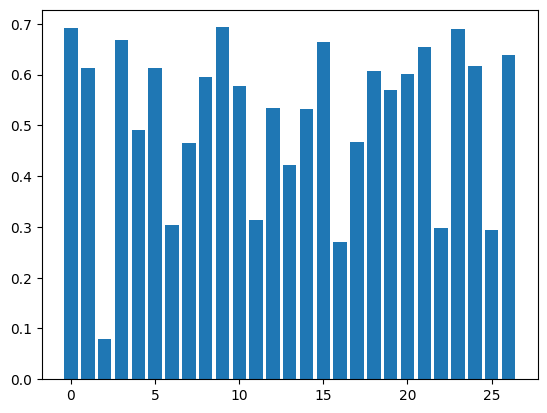

In [4]:
|import matplotlib.pyplot as plt
import numpy as np

len(toxicity.smiles)
p = toxicity.y.mean(0)
h = - p * p.log() - (1-p) * (1-p).log()
plt.bar(np.arange(len(h)), h)

In [10]:
smiles = toxicity.smiles
targets = toxicity.y

In [6]:
fp_extractor = PubChem(timeout=10000, threads=24)

In [7]:
fingerprints = fp_extractor.encode_all(smiles[:64])

<BarContainer object of 881 artists>

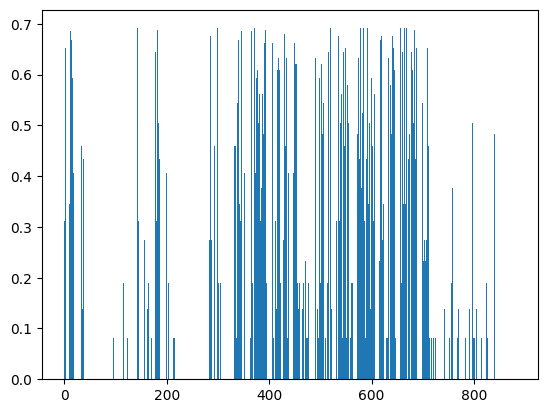

In [8]:
import matplotlib.pyplot as plt
import numpy as np

p = fingerprints.mean(0)
h = torch.nan_to_num(-p * p.log() - (1-p) * (1-p).log())

plt.bar(np.arange(fp_extractor.n_dim), h.data.numpy())

In [12]:
from torch_mist.estimators import smile
from torch_mist.utils.train import train_mi_estimator

estimator = smile(
    x_dim=fp_extractor.n_dim,
    y_dim=targets.shape[1],
    hidden_dims=[64, 32],
    neg_samples=32,
)

train_log = train_mi_estimator(
    estimator,
    x=fingerprints,
    y=targets[:len(fingerprints)],
    max_epochs=100,
    batch_size=128,
)


Iteration: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s, loss: 1.1541024446487427]


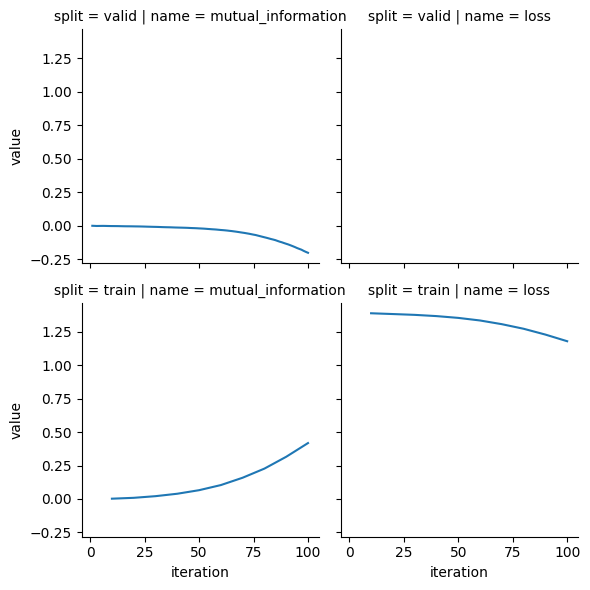

In [15]:
import seaborn as sns
grid = sns.FacetGrid(train_log, col='name', row='split')
grid.map(sns.lineplot, 'iteration', 'value')

<BarContainer object of 881 artists>

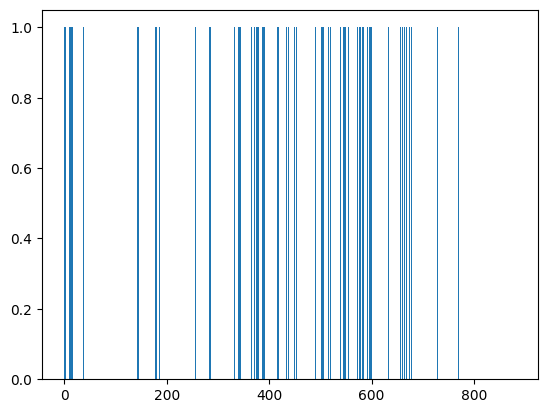

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(np.arange(881), fpv)

In [47]:
from caching.cached_dict import CachedTensorDict
import numpy as np
cached_dict = CachedTensorDict('.', 'test', shape=(8,))

In [48]:
cached_dict.max_idx, cached_dict.shape

(1, (3, 8))

In [49]:
(cached_dict.max_idx+1, *cached_dict._base_shape)

(2, 8)

In [50]:
cached_dict['apple']

array([1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32)

In [51]:
cached_dict['apple'] = np.arange(8)+1

In [52]:
cached_dict._index

{'apple': 0, 'orange': 1, 'banana': -1}

In [53]:
cached_dict._cache

<HDF5 dataset "data": shape (2, 8), type "<f4">

In [54]:
cached_dict._new_cache

{}

In [55]:
cached_dict._write_new_cache_to_disk()

In [56]:
del cached_dict

In [36]:
!pwd

/home/marco/Documents/InfoMol/notebooks


In [58]:
import numpy as np
values = np.array([10, 11, 12, 13, 14, 15])

def get_values(ids):
    assert np.all(ids[:-1]<ids[1:])
    return values[ids]

def sorted_access(ids):
    ids = np.array(ids).astype(np.int32)
    # Make sure the ids are ordered
    if not np.all(ids[:-1] < ids[1:]):
        # Step 1: Sort the IDs and remember the original indices
        id_order = np.argsort(ids)
        sorted_ids = ids[id_order]
        id_lookup = np.arange(id_order.shape[0])

        # Step 1.5: Check for duplicate ids and remove them from the query
        duplicates = not np.all(sorted_ids[:-1] < sorted_ids[1:])
        if duplicates:
            non_duplicate_mask = np.concatenate(
                [np.array([True]).reshape(1), sorted_ids[:-1] < sorted_ids[1:]], 0
            )
            sorted_ids = sorted_ids[non_duplicate_mask]
            id_lookup = np.cumsum(non_duplicate_mask)-1
        else:
            id_lookup = np.arange(id_order.shape[0])

        # Step 2: Access the array using the sorted IDs
        values = get_values(sorted_ids)
        
        # Step 3: Sort the values back to the original order
        inverse_ids = np.empty_like(id_order)
        inverse_ids[id_order] = id_lookup

        print(ids, id_order, sorted_ids, values, id_lookup, inverse_ids)
        
        values = values[inverse_ids]
    else:
        values = get_values(ids)
    return values



In [60]:
ids = [1]
assert np.all(sorted_access(ids)==values[ids])

In [39]:
with open('descriptors.xml', 'r') as file:
    print(file.readlines())

['<?xml version="1.0" encoding="utf-8"?>\n', '<Root>\n', '    <Group name="Fingerprint">\n', '        <Descriptor name="Fingerprinter" value="false"/>\n', '        <Descriptor name="ExtendedFingerprinter" value="false"/>\n', '        <Descriptor name="EStateFingerprinter" value="false"/>\n', '        <Descriptor name="GraphOnlyFingerprinter" value="false"/>\n', '        <Descriptor name="MACCSFingerprinter" value="true"/>\n', '        <Descriptor name="PubchemFingerprinter" value="false"/>\n', '        <Descriptor name="SubstructureFingerprinter" value="false"/>\n', '        <Descriptor name="SubstructureFingerprintCount" value="false"/>\n', '        <Descriptor name="KlekotaRothFingerprinter" value="true"/>\n', '        <Descriptor name="KlekotaRothFingerprintCount" value="false"/>\n', '        <Descriptor name="AtomPairs2DFingerprinter" value="false"/>\n', '        <Descriptor name="AtomPairs2DFingerprintCount" value="false"/>\n', '    </Group>\n', '</Root>\n']


In [ ]:
        <Descriptor name="Fingerprinter" value="false"/>
        <Descriptor name="ExtendedFingerprinter" value="false"/>
        <Descriptor name="EStateFingerprinter" value="false"/>
        <Descriptor name="GraphOnlyFingerprinter" value="false"/>
        <Descriptor name="MACCSFingerprinter" value="true"/>
        <Descriptor name="PubchemFingerprinter" value="false"/>
        <Descriptor name="SubstructureFingerprinter" value="false"/>
        <Descriptor name="SubstructureFingerprintCount" value="false"/>
        <Descriptor name="KlekotaRothFingerprinter" value="true"/>
        <Descriptor name="KlekotaRothFingerprintCount" value="false"/>
        <Descriptor name="AtomPairs2DFingerprinter" value="false"/>
        <Descriptor name="AtomPairs2DFingerprintCount" value="false"/>